In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import astropy.units as u
import os
from itertools import combinations

from toolkit import (get_phoenix_model_spectrum, EchelleSpectrum, ModelGrid,
                     slice_spectrum, concatenate_spectra, bands_TiO, instr_model)
model_grid = ModelGrid()

n_fit_params = 3 #4

# Limit combinations such that delta T < 3000 K
# temp_combinations = [i for i in combinations(model_grid.test_temps, 2) 
#                      if (abs(i[0] - i[1]) <= 3000) and (4000 < i[1] < 5000)]

fixed_temp_phot = 4780
fixed_temp_spot = fixed_temp_phot - 300

fits_files = []

for dirpath, dirnames, files in os.walk('/local/tmp/freckles/data/'):
    for file in files:
        file_path = os.path.join(dirpath, file)
        if (file_path.endswith('.fits') and ('weird' not in file_path) 
             and ('dark' not in file_path) and ('HAT' in file_path)):
            fits_files.append(file_path)

fits_files = fits_files[1:]

new_paths = []
for path in fits_files: 
    split_name = path.split(os.sep)
    date = split_name[-2]
    fname = split_name[-1].split('.')
    new_paths.append('fits/' + '.'.join([date] + fname[:2]) + '.npy')
    
    
def plot_spliced_spectrum(observed_spectrum, model_flux, other_model=None):
    n_chunks = len(slices.wavelength_splits)
    fig, ax = plt.subplots(n_chunks, 1, figsize=(8, 10))

    for i, inds in enumerate(observed_spectrum.wavelength_splits):
        min_ind, max_ind = inds

        ax[i].errorbar(observed_spectrum.wavelength[min_ind:max_ind].value, 
                       observed_spectrum.flux[min_ind:max_ind], 
                       0.025*np.ones(max_ind-min_ind))
        ax[i].plot(observed_spectrum.wavelength[min_ind:max_ind], 
                   model_flux[min_ind:max_ind])
        
        if other_model is not None:
            ax[i].plot(observed_spectrum.wavelength[min_ind:max_ind], 
                       other_model[min_ind:max_ind], alpha=0.4)
        
        ax[i].set_xlim([observed_spectrum.wavelength[max_ind-1].value, 
                        observed_spectrum.wavelength[min_ind].value])
        ax[i].set_ylim([0.9*observed_spectrum.flux[min_ind:max_ind].min(), 
                        1.1])

    return fig, ax

def nearest_order(spectrum, wavelength):
    return np.argmin([abs(spec.wavelength.mean() - wavelength).value
                      for spec in spectrum.spectrum_list])


def plot_bfgs_params(n_fit_params, n_combinations, temp_combinations, best_parameters):
    fig, ax = plt.subplots(n_fit_params, 1, figsize=(14, 8), sharex=True)
    for i in range(n_fit_params):
        ax[i].plot(best_parameters[:, i]);

    xticks = np.arange(0, n_combinations, 1)

    ax[-1].set_xticks(xticks)
    #xticklabels = [', '.join(map(str, x)) for x in np.array(temp_combinations)[xticks, :]]
    #ax[-1].set_xticklabels(xticklabels)
    ax[-1].set_xticklabels([t[0] for t in temp_combinations])
    #ax[-1].set_ylim([0, 5])

    for l in ax[-1].get_xticklabels():
        l.set_rotation(30)
        l.set_ha('right')

    ax[0].set_ylabel('covering fraction')
    ax[1].set_ylabel('wavelength offset')
    #ax[2].set_ylabel('broadening coeff')
    ax[2].set_ylabel('$\chi^2$')
    return fig, ax


def soln_contours(best_parameters, temp_combinations):

    area = best_parameters[:, 0]
    #chi2 = best_parameters[:, 3]
    chi2 = best_parameters[:, 2]
    temp_phots = np.array([t[1] for t in temp_combinations])
    temp_spots = np.array([t[0] for t in temp_combinations])

    cmap = plt.cm.viridis_r

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    cax = ax[0].tricontourf(temp_phots, temp_spots, area, cmap=cmap)
    cbar = plt.colorbar(cax, ax=ax[0])
    cbar.set_label('area', fontsize=16)
    ax[0].set(xlabel='Phot', ylabel='Spot')

    cax = ax[1].tricontourf(temp_phots, temp_spots, np.log10(chi2), cmap=cmap)
    cbar = plt.colorbar(cax, ax=ax[1])
    cbar.set_label('$\log \, \chi^2$', fontsize=16)
    ax[1].set(xlabel='Phot', ylabel='Spot')

    for axis in ax:
        axis.grid(ls=':')

    fig.subplots_adjust(wspace=0.35)
    return fig, ax

In [2]:
def nearest_order(spectrum, wavelength):
    return np.argmin([abs(spec.wavelength.mean() - wavelength).value
                      for spec in spectrum.spectrum_list])

home_dir = '/local/tmp/freckles/' if os.uname().sysname == 'Linux' else os.path.expanduser('~')
standard_path = os.path.join(home_dir, 'data/Q3UW04/UT160706/BD28_4211.0034.wfrmcpc.fits')
standard_spectrum = EchelleSpectrum.from_fits(standard_path)

in_path = fits_files[0]
#in_path = os.path.join('/run/media/bmmorris/PASSPORT/APO/Q3UW04/UT160703',
#                       'KIC9652680.0028.wfrmcpc.fits')
                        #'KIC9652680.0025.wfrmcpc.fits')#fits_files[-2]
print(in_path)
target_spectrum = EchelleSpectrum.from_fits(in_path)
only_orders = list(range(len(target_spectrum.spectrum_list)))
target_spectrum.continuum_normalize(standard_spectrum,
                                    polynomial_order=10,
                                    only_orders=only_orders,
                                    plot_masking=False)

rv_shifts = u.Quantity([target_spectrum.rv_wavelength_shift(order, T_eff=5618)
                        for order in only_orders])
median_rv_shift = np.median(rv_shifts)

target_spectrum.offset_wavelength_solution(median_rv_shift)

spec_band = []
for band in bands_TiO:
    band_order = target_spectrum.get_order(nearest_order(target_spectrum, band.core))
    target_slice = slice_spectrum(band_order, band.min, band.max)
#     target_slice = slice_spectrum(band_order, band.min, band.max)
    target_slice.flux /= target_slice.flux.max()
    spec_band.append(target_slice)
slices = concatenate_spectra(spec_band)

/local/tmp/freckles/data/Q3UW04/UT160706/HAT-P-11.0036.wfrmcpc.fits


In [3]:
model_phot = model_grid.spectrum(fixed_temp_phot)
model_spot = model_grid.spectrum(fixed_temp_spot)

In [28]:
from scipy.signal import gaussian
from toolkit import combine_spectra


err_bar = 0.01
res = 1
kernel = gaussian(int(5*res), res)


def instr_model_fixed(spotted_area, lam_offset, res, observed_spectrum, 
                      err_bar=err_bar):
    
    kernel = gaussian(int(5*res), res)
    combined_spectrum = combine_spectra(model_phot, model_spot, spotted_area)
    combined_spectrum.convolve(kernel=kernel)

    # Apply wavelength correction just to red wavelengths:
    corrected_wavelengths = observed_spectrum.wavelength.copy()
    red_wavelengths = corrected_wavelengths > 7000*u.Angstrom
    blue_wavelengths = np.logical_not(red_wavelengths)
    corrected_wavelengths[red_wavelengths] -= lam_offset*u.Angstrom
    corrected_wavelengths[blue_wavelengths] -= (lam_offset + 0.35)*u.Angstrom
    combined_interp = combined_spectrum.interpolate(corrected_wavelengths)

    combined_scaled = combined_interp.copy()
    residuals = 0
    for i_min, i_max in observed_spectrum.wavelength_splits:
        c, residuals_i = np.linalg.lstsq(combined_interp[i_min:i_max, np.newaxis],
                                         observed_spectrum.flux[i_min:i_max, np.newaxis])[0:2]
        residuals += residuals_i
        combined_scaled[i_min:i_max] = combined_interp[i_min:i_max] * c[0]

    residuals /= err_bar**2

    return combined_scaled, residuals/err_bar**2

In [35]:
import emcee

def lnprior(theta):
    lna, dlam, res = theta
    if (-10 < lna < 0) and (-20 < dlam < 20) and (0 < res < 10):#(-10 < dlam < 10):
        return 0.0
    return -np.inf

def lnlike(theta):
    lna, dlam, res = theta
    model, residuals = instr_model_fixed(np.exp(lna), dlam, res, slices)
    return -0.5*residuals

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

ndim, nwalkers = 3, 6
pos = []

while len(pos) < nwalkers: 
    try_this = (np.array([np.log(0.3), -1.57, 1.8]) + 
                np.array([2*np.random.randn(), 
                          0.1*np.random.randn(), 
                          0.3*np.random.randn()]))
    if np.isfinite(lnlike(try_this)):
        pos.append(try_this)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [36]:
print("Running MCMC burn-in...")
pos1 = sampler.run_mcmc(pos, 50)[0]#, rstate0=np.random.get_state())

print("Running MCMC...")
sampler.reset()
pos2 = sampler.run_mcmc(pos1, 500)[0]

print("Running MCMC...")
sampler.reset()
pos3 = sampler.run_mcmc(pos2, 1500)[0]

print("Done.")

Running MCMC burn-in...


/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Running MCMC...
Running MCMC...
Done.


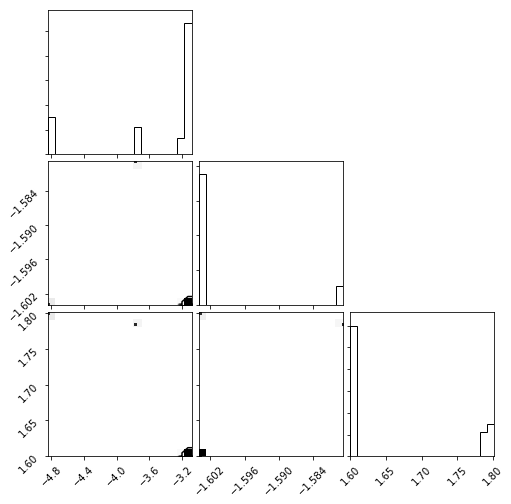

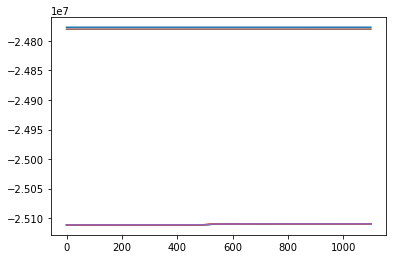

In [37]:
from corner import corner

samples = sampler.flatchain[400:, :]
#samples[:, 0] = np.exp(samples[:, 0])
corner(samples, );

plt.figure()
plt.plot(sampler.lnprobability[:, 400:].T)

In [40]:
best_dlam

-1.5788160621359519

0.0228275424602 -1.57881606214 1.78543585481


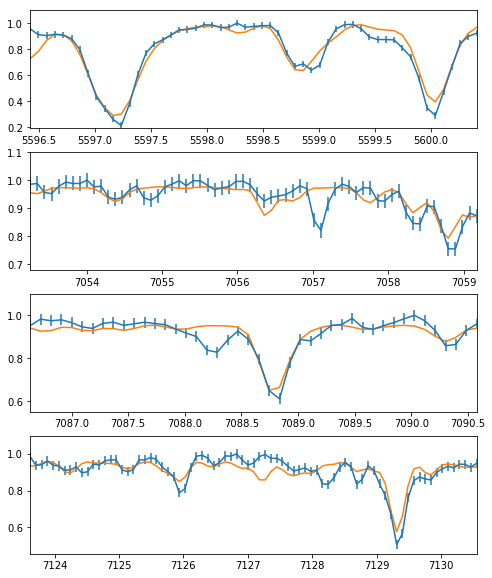

In [41]:
best_step_ind = np.argmax(sampler.flatlnprobability)
best_step = sampler.flatchain[best_step_ind, :]
best_area, best_dlam, best_res = np.exp(best_step[0]), best_step[1], best_step[2]
print(best_area, best_dlam, best_res)

best_model, resid = instr_model_fixed(best_area, best_dlam, 
                                      best_res, slices)
plot_spliced_spectrum(slices, best_model);